In [37]:
from fastai import *
from fastai.vision import *
from pathlib import Path
import cv2

In [74]:
path = Path('data/')
path_lbl = path/'labels'
path_img = path/'images'
path_poly = path/'polys'

### prep

In [72]:
def find_image(file_path):
    for im_path in path_img.iterdir():
        if im_path.stem == file_path.stem: return im_path
    raise Exception(f'No {file_path} image')

def read_polys(json_path):
    data = json.load(open(json_path))['shapes'][0]
    return data['label'], np.array(data['points'], dtype=int) # [N,2] shape

def convert_polys_to_segmentation():
    for json_path in progress_bar(list(path_poly.iterdir())):
        im_path = find_image(json_path)
        im = cv2.imread(str(im_path))
        lbl, polys = read_polys(json_path)
        mask = np.zeros(im.shape[:2], dtype=np.float32)
        mask = cv2.fillPoly(mask, [polys.reshape((-1,1,2))], (255,255,255))
        out_path = path_lbl/(json_path.stem+'.png')
        seg = ImageSegment(tensor(mask)[None] / 255.)
        seg.save(out_path)
    #     seg.show()

In [73]:
# convert_polys_to_segmentation()

### helper funcs

In [78]:
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'

In [75]:
img_names = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

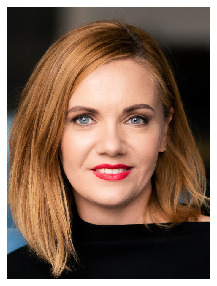

In [81]:
open_image(img_names[0]).show(figsize=(5,5))

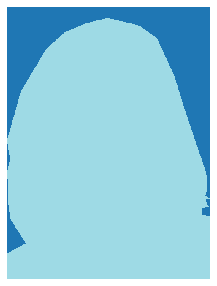

In [82]:
open_mask(get_y_fn(img_names[0])).show(figsize=(5,5), alpha=1)

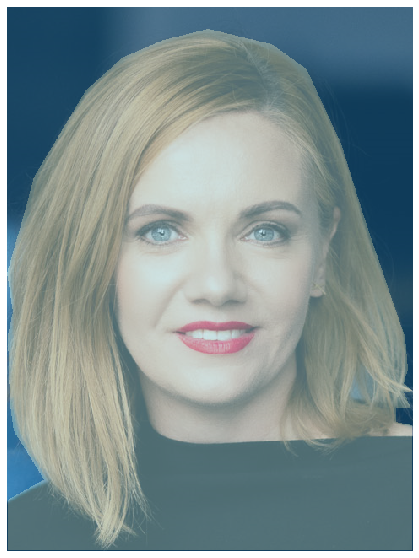

In [464]:
img = open_image(img_names[0])
mask = open_mask(get_y_fn(img_names[0]))
img.show(y=mask, figsize=(10,10))

In [465]:
# opencv <-> fastai Image funcs
img2np = lambda im: image2np(im.data.float()*255).astype(np.uint8)
def img2np(im):
    mult = 1. if type(im) == ImageSegment else 255.
    return image2np(im.data.float()*mult).astype(np.uint8)

def np2img(im, Class=Image):
    if len(im.shape) == 2: im = im[:,:,None]
    mult = 1. if Class == ImageSegment else 255.
    return Class(tensor(im).float().permute(2,0,1)/mult)

In [466]:
print(mask.shape, img.shape)
np_mask, np_img = img2np(mask), img2np(img)
print(np_mask.shape, np_img.shape)
mask, img = np2img(np_mask, Class=ImageSegment), np2img(np_img, Class=Image)
print(mask.shape, img.shape)

torch.Size([1, 645, 481]) torch.Size([3, 645, 481])
(645, 481) (645, 481, 3)
torch.Size([1, 645, 481]) torch.Size([3, 645, 481])


#### Face and Eye detector

more cascades:  
http://alereimondo.no-ip.org/OpenCV/34  
https://github.com/opencv/opencv/tree/master/data/haarcascades

In [405]:
face_cascade = cv2.CascadeClassifier()
face_cascade.load(cv2.samples.findFile('haarcascades/haarcascade_frontalface_default.xml'))
# face_cascade.load(cv2.samples.findFile('haarcascades/haarcascade_profileface.xml'))
eyes_cascade = cv2.CascadeClassifier()
eyes_cascade.load(cv2.samples.findFile('haarcascades/haarcascade_eye_tree_eyeglasses.xml'))
# eyes_cascade.load(cv2.samples.findFile('haarcascades/haarcascade_eye.xml'))
# eyes_cascade.load(cv2.samples.findFile('haarcascades/haarcascade_righteye_2splits.xml'))
# eyes_cascade.load(cv2.samples.findFile('haarcascades/haarcascade_lefteye_2splits.xml'))
smile_cascade = cv2.CascadeClassifier()
smile_cascade.load(cv2.samples.findFile('haarcascades/haarcascade_smile.xml'))

True

In [392]:
def cascade_detect_regions(img, cascade_classifier):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.equalizeHist(img_gray)
    regions = cascade_classifier.detectMultiScale(img_gray)
    return [ (t,l,t+h,l+w) for (l,t,w,h) in regions] # out: (t,l,b,r)

In [397]:
detect_faces = lambda img: cascade_detect_regions(img, face_cascade)
detect_eyes = lambda img: cascade_detect_regions(img, eyes_cascade)
detect_smiles = lambda img: cascade_detect_regions(img, smile_cascade)

In [398]:
def show_cascade_example(img, cascade_func=detect_faces):
    out = np.zeros_like(img)
    for t,l,b,r in cascade_func(img):
        out[t:b , l:r] = img[t:b , l:r]
    return np2img(out).show()

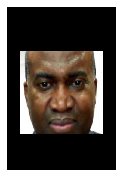

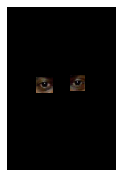

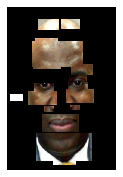

In [406]:
show_cascade_example(img, detect_faces)
show_cascade_example(img, detect_eyes)
show_cascade_example(img, detect_smiles)

### testing

In [467]:
resize_img = lambda im, size: im.resize((im.data.shape[0], size[0], size[1]))

In [468]:
def get_random_np_img_and_mask(size=(600,400)):
    im_fn = random.choice(list(path_img.iterdir()))
    img, mask_true = open_image(im_fn), open_mask(get_y_fn(im_fn))
    img, mask_true = resize_img(img, size), resize_img(mask_true, size)
    return img2np(img), img2np(mask_true)

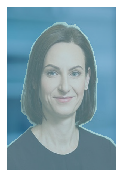

In [469]:
img, mask = get_random_np_img_and_mask()
np2img(img).show(y=np2img(mask, Class=ImageSegment))

In [470]:
def acc(y_pred, y_true): # torch tensors w/ shape [b,h,w]
    return (y_pred == y_true).float().mean()

In [476]:
def test_algorithm(f, metrics=[acc], size=(600,400), progress=False):
    # f = f(img[h,w,3], mask_true[h,w]) -> mask_pred[h,w] (numpy arrays), (mask: 0-bg, 1-fg)
    img_paths = list(path_img.iterdir())
    mask_preds, mask_trues = torch.zeros(len(img_paths), *size), torch.zeros(len(img_paths), *size)
    if progress: img_paths = progress_bar(img_paths)
    for i,im_fn in enumerate(img_paths):
        img, mask_true = open_image(im_fn), open_mask(get_y_fn(im_fn))
        img, mask_true = resize_img(img, size), resize_img(mask_true, size)
        np_img, np_mask_true = img2np(img), img2np(mask_true) # normalize to: 0-bg, 1-fg
        np_mask_pred = f(np_img, np_mask_true)
        mask_preds[i] = tensor(np_mask_pred)
        mask_trues[i] = tensor(np_mask_true)
    return tensor([ m(mask_preds, mask_trues) for m in metrics ])

In [780]:
def show_worse_results(f, num_items, metric_func=acc, size=(600,400), progress=False):
    # f = f(img[h,w,3], mask_true[h,w]) -> mask_pred[h,w] (numpy arrays), (mask: 0-bg, 1-fg)
    img_paths = list(path_img.iterdir())
    mask_preds, mask_trues = torch.zeros(len(img_paths), *size), torch.zeros(len(img_paths), *size)
    if progress: iter_img_paths = progress_bar(img_paths)
    results = []
    for i,im_fn in enumerate(iter_img_paths):
        img, mask_true = open_image(im_fn), open_mask(get_y_fn(im_fn))
        img, mask_true = resize_img(img, size), resize_img(mask_true, size)
        np_img, np_mask_true = img2np(img), img2np(mask_true)
        np_mask_pred = f(np_img, np_mask_true)
        mask_pred = tensor(np_mask_pred)
        mask_true = tensor(np_mask_true)
        results.append( metric_func(mask_pred[None], mask_true[None]) )
    for i,res in sorted(enumerate(results), key=lambda x:x[1])[:num_items]:
        im_fn = img_paths[i]
        img, mask_true = open_image(im_fn), open_mask(get_y_fn(im_fn))
        img, mask_true = resize_img(img, size), resize_img(mask_true, size)
        np_img, np_mask_true = img2np(img), img2np(mask_true)
        mask_pred = np2img(f(np_img, np_mask_true))
        print(res)
        img.show(y=mask_true)
        img.show(y=mask_pred)

In [477]:
return_true_mask = lambda img, mask_true: mask_true
test_algorithm(return_true_mask)

tensor([1.])

In [478]:
return_random_mask = lambda img, mask_true: np.random.randint(0,2, size=mask_true.shape, dtype=np.uint8)
test_algorithm(return_random_mask)

tensor([0.5001])

In [479]:
return_zero_mask = lambda img, mask_true: np.zeros(mask_true.shape, dtype=np.uint8)
test_algorithm(return_zero_mask)

tensor([0.3833])

In [480]:
return_ones_mask = lambda img, mask_true: np.ones(mask_true.shape, dtype=np.uint8)
test_algorithm(return_ones_mask)

tensor([0.6167])

### Grab Cut

In [766]:
img, mask = get_random_np_img_and_mask()

#### grab cut naked

In [484]:
def grab_cut_naked(img, _):
    h,w,c = img.shape
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    rect = (0,0,h,w)
    mask = np.zeros(img.shape[:2],np.uint8)
    mask, bgdModel, fgdModel = cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    return np.where((mask==2)|(mask==0),0,1).astype('uint8')

In [485]:
%%timeit
grab_cut_naked(img, mask)

1.78 s ± 117 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [486]:
test_algorithm(grab_cut_naked, progress=True)

tensor([0.3843])

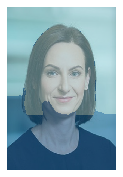

In [488]:
np2img(img).show(y=np2img(grab_cut_naked(img, mask), Class=ImageSegment))

#### grab cut with side bg mask and middle pixels as fg

In [592]:
def find_bg_only_regions(size=(600,400)): # 1's - bg only regions
    bg_mask = np.ones(size, dtype=bool)
    for im_fn in path_img.iterdir():
        mask = open_mask(get_y_fn(im_fn))
        mask = resize_img(mask, size)
        np_mask = 1. - img2np(mask)
        bg_mask *= np_mask.astype(bool)
    return bg_mask.astype(np.uint8)

(tensor([0, 1], dtype=torch.uint8), tensor([202793,  37207]))

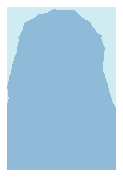

In [593]:
bg_mask = find_bg_only_regions()
np2img(bg_mask, Class=ImageSegment).show()
tensor(bg_mask).unique(return_counts=True)

In [548]:
def grab_cut_bg_mask(img, _, pad=10, iters=5, be_sure=True):
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    mask = bg_mask.copy()
    mask[bg_mask == 1] = cv2.GC_BGD
    mask[bg_mask == 0] = cv2.GC_PR_FGD
    mask, bgdModel, fgdModel = cv2.grabCut(img,mask,None,bgdModel,fgdModel,iters,cv2.GC_INIT_WITH_MASK)
    return mask if not be_sure else np.where((mask==cv2.GC_PR_BGD)|(mask==cv2.GC_BGD),0,1).astype('uint8')

In [549]:
%%timeit
grab_cut_bg_mask(img, mask)

1.17 s ± 54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [550]:
test_algorithm(grab_cut_bg_mask, progress=True)

tensor([0.9430])

In [551]:
cv2.GC_BGD, cv2.GC_FGD, cv2.GC_PR_BGD, cv2.GC_PR_FGD

(0, 1, 2, 3)

(tensor([0, 2, 3], dtype=torch.uint8), tensor([ 37207,  56899, 145894]))

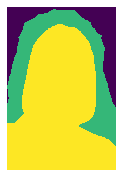

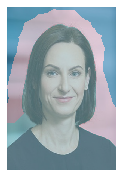

In [552]:
mask_pred = grab_cut_bg_mask(img, mask, be_sure=False)
np2img(mask_pred, Class=Image).show()
np2img(img).show(y=np2img(mask_pred, Class=ImageSegment))
tensor(mask_pred).unique(return_counts=True)

#### Same just mask fg is found by face, eye detector

In [584]:
def grab_cut_face_mask(img, _, face_pct=.4, eyes_pct=1.3, iters=5, be_sure=True):
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    mask = bg_mask.copy()
    mask[bg_mask == 1] = cv2.GC_BGD
    mask[bg_mask == 0] = cv2.GC_PR_FGD
    # put faces and eyes in mask
    eyes = detect_eyes(img)
    faces = detect_faces(img)
    for pct, regions in [(face_pct,faces),(eyes_pct,eyes)]:
        for t,l,b,r in regions:
            h,w = b-t,r-l
            h_pad, w_pad = (h-int(pct*h))//2, (w-int(pct*w))//2
            t,l,b,r = t+h_pad,l+w_pad,b-h_pad,r-w_pad
            mask[t:b , l:r] = cv2.GC_FGD
    mask, bgdModel, fgdModel = cv2.grabCut(img,mask,None,bgdModel,fgdModel,iters,cv2.GC_INIT_WITH_MASK)
    return mask if not be_sure else np.where((mask==cv2.GC_PR_BGD)|(mask==cv2.GC_BGD),0,1).astype('uint8')

In [596]:
%%timeit
grab_cut_face_mask(img, mask)

1.26 s ± 57.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


(tensor([0, 1, 2, 3], dtype=torch.uint8),
 tensor([ 37207,  11948,  52178, 138667]))

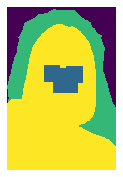

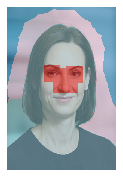

In [585]:
mask_pred = grab_cut_face_mask(img, mask, be_sure=False)
np2img(mask_pred, Class=Image).show()
np2img(img).show(y=np2img(mask_pred, Class=ImageSegment))
tensor(mask_pred).unique(return_counts=True)

In [586]:
test_algorithm(grab_cut_face_mask, progress=True)

tensor([0.9442])

#### fg and bg are chosen from only fg/bg regions

In [605]:
def find_fg_only_regions(size=(600,400)): # 1's - bg only regions
    bg_mask = np.ones(size, dtype=bool)
    for im_fn in path_img.iterdir():
        mask = open_mask(get_y_fn(im_fn))
        mask = resize_img(mask, size)
        np_mask = img2np(mask)
        bg_mask = bg_mask * np_mask.astype(bool)
    return bg_mask.astype(np.uint8)

In [606]:
fg_mask = find_fg_only_regions()
tensor(fg_mask).unique(return_counts=True)

(tensor([0, 1], dtype=torch.uint8), tensor([150711,  89289]))

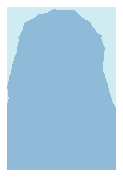

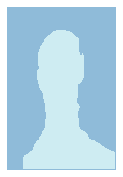

In [607]:
np2img(bg_mask, Class=ImageSegment).show()
np2img(fg_mask, Class=ImageSegment).show()

In [599]:
def grab_cut_bg_fg_mask(img, _, iters=5, be_sure=True, bg_true=cv2.GC_BGD, fg_true=cv2.GC_FGD, other_area=cv2.GC_PR_FGD):
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    mask = bg_mask.copy()
    mask[bg_mask == 0] = other_area
    mask[bg_mask == 1] = bg_true
    mask[fg_mask == 1] = fg_true
    mask, bgdModel, fgdModel = cv2.grabCut(img,mask,None,bgdModel,fgdModel,iters,cv2.GC_INIT_WITH_MASK)
    return mask if not be_sure else np.where((mask==cv2.GC_PR_BGD)|(mask==cv2.GC_BGD),0,1).astype('uint8')

In [600]:
f = partial(grab_cut_bg_fg_mask, bg_true=cv2.GC_BGD, fg_true=cv2.GC_FGD, other_area=cv2.GC_PR_FGD)
test_algorithm(f, progress=True)

tensor([0.9478])

In [601]:
f = partial(grab_cut_bg_fg_mask, bg_true=cv2.GC_BGD, fg_true=cv2.GC_PR_FGD, other_area=cv2.GC_PR_BGD)
test_algorithm(f, progress=True)

tensor([0.8757])

(tensor([0, 1, 2, 3], dtype=torch.uint8), tensor([37207, 89289, 52170, 61334]))

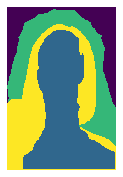

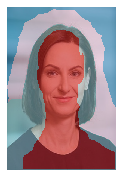

In [608]:
mask_pred = grab_cut_bg_fg_mask(img, mask, be_sure=False)
np2img(mask_pred, Class=Image).show()
np2img(img).show(y=np2img(mask_pred, Class=ImageSegment))
tensor(mask_pred).unique(return_counts=True)

#### manually created mask

In [735]:
def kmeans(img, K=4, iters=10, epsilon=1.0):
    Z = img.reshape((-1,img.shape[-1])).astype(np.float32)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, iters, epsilon)
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    return center.astype(np.uint8)[label.flatten()].reshape(img.shape)

In [740]:
def prep_paint_mask(in_im=path/'masks'/'paint_original.png', out_im=path/'masks'/'paint.png'):
    img = cv2.imread(str(in_im))
    img = kmeans(img, K=4, iters=100)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(img)
    print('K:', len(np.unique(img)))
    for i,px in enumerate(np.unique(img)):
        mask[img == px] = i
    new_mask = np2img(mask, Class=ImageSegment)
    new_mask.save(out_im)
    new_mask.show()
    return out_im

K: 4


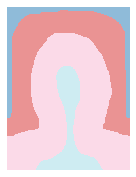

In [741]:
comp_mask_path = prep_paint_mask()

In [748]:
comp_mask = open_mask(comp_mask_path)
comp_mask = resize_img(comp_mask, (600,400))
comp_mask.data.unique(return_counts=True)

(tensor([0, 1, 2, 3]), tensor([ 24572,  80032, 110434,  24962]))

In [753]:
comp_mask_BG, comp_mask_FG = 0, 3
comp_mask_PR_BG, comp_mask_PR_FG = 1, 2

In [754]:
# ImageSegment(comp_mask.data == comp_mask_PR_FG)

In [760]:
comp_mask = img2np(comp_mask)

In [763]:
def grab_cut_custom_mask(img, _, iters=5, be_sure=True):
    assert comp_mask.shape == img.shape[:2]
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    mask = comp_mask.copy()
    mask[comp_mask == comp_mask_BG] = cv2.GC_BGD
    mask[comp_mask == comp_mask_FG] = cv2.GC_FGD
    mask[comp_mask == comp_mask_PR_BG] = cv2.GC_PR_BGD
    mask[comp_mask == comp_mask_PR_FG] = cv2.GC_PR_FGD
    mask, bgdModel, fgdModel = cv2.grabCut(img,mask,None,bgdModel,fgdModel,iters,cv2.GC_INIT_WITH_MASK)
    return mask if not be_sure else np.where((mask==cv2.GC_PR_BGD)|(mask==cv2.GC_BGD),0,1).astype('uint8')

In [764]:
test_algorithm(grab_cut_custom_mask, progress=True)

tensor([0.9300])

tensor(0.6320)
tensor(0.7271)
tensor(0.9023)
tensor(0.9123)
tensor(0.9189)


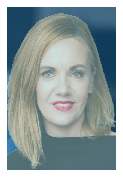

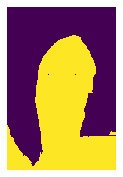

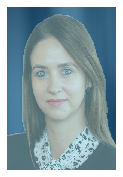

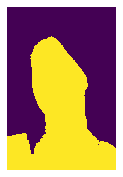

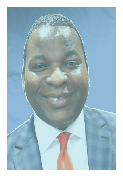

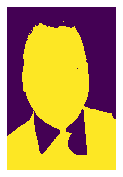

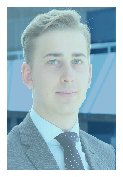

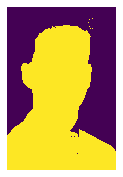

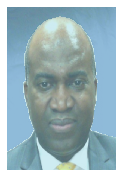

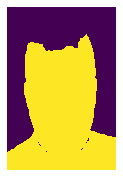

In [779]:
show_worse_results(grab_cut_custom_mask, 5, progress=True)

In [775]:
a = [1,6,5,3,9]
sorted(enumerate(a), key=lambda x:x[1])[:3]

[(0, 1), (3, 3), (2, 5)]

In [ ]:
def test_algorithm(f, metrics=[acc], size=(600,400), progress=False):
    # f = f(img[h,w,3], mask_true[h,w]) -> mask_pred[h,w] (numpy arrays), (mask: 0-bg, 1-fg)
    img_paths = list(path_img.iterdir())
    mask_preds, mask_trues = torch.zeros(len(img_paths), *size), torch.zeros(len(img_paths), *size)
    if progress: img_paths = progress_bar(img_paths)
    for i,im_fn in enumerate(img_paths):
        img, mask_true = open_image(im_fn), open_mask(get_y_fn(im_fn))
        img, mask_true = resize_img(img, size), resize_img(mask_true, size)
        np_img, np_mask_true = img2np(img), img2np(mask_true) # normalize to: 0-bg, 1-fg
        np_mask_pred = f(np_img, np_mask_true)
        mask_preds[i] = tensor(np_mask_pred)
        mask_trues[i] = tensor(np_mask_true)
    return tensor([ m(mask_preds, mask_trues) for m in metrics ])

(tensor([0, 1, 2, 3], dtype=torch.uint8),
 tensor([ 24572,  24962,  76263, 114203]))

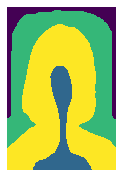

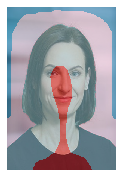

In [769]:
mask_pred = grab_cut_custom_mask(img, mask, be_sure=False)
np2img(mask_pred, Class=Image).show()
np2img(img).show(y=np2img(mask_pred, Class=ImageSegment))
tensor(mask_pred).unique(return_counts=True)